## Applied Data Science Project

Hugo Bossi, Fabian Frieden, Domenic Largiadèr

### Choosing the appropriate alogrithm for prediction

After we have now consolidated our data from a CSV File and from a NBA Website into a Dataframe, we would like to consider
the appropriate alogirthm for our prediction. We would like to predict what the probability is, that a NBA Team is qualifying for playoffs based on this historical data from 2011 to 2022. 

@Fabian: Brauche als ausgangslage das Dataframe 'final_df'

In [41]:
#Before we jump into the development of a ML model,
#we would also like to transform the categorical variable "playoffs" into binary for "True" and "False"

# Importing LabelEncoder from Sklearn
# library from preprocessing Module.
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(final_df['playoffs'])
 
# printing label
label

# removing the column 'Purchased' from df
# as it is of no use now.
final_df.drop("playoffs", axis=1, inplace=True)
 
# Appending the array to our dataFrame
# with column name 'playoffs'
final_df["playoffs"] = label

In [42]:
#show df after transformation
final_df

final_df.isna().sum()

season              0
Team                0
age                 0
w                   0
l                   0
pw                  0
pl                  0
mov                 0
sos                 0
srs                 0
o_rtg               0
d_rtg               0
n_rtg               0
pace                0
f_tr                0
x3p_ar              0
ts_percent          0
e_fg_percent        0
tov_percent         0
orb_percent         0
ft_fga              0
opp_e_fg_percent    0
opp_tov_percent     0
opp_drb_percent     0
opp_ft_fga          0
attend              0
attend_g            0
Conf                0
Div                 0
W_L_Per             0
MOV_A               0
ORtg_A              0
DRtg_A              0
NRtg_A              0
Rk                  0
playoffs            0
dtype: int64

season            pace                0.779183
pace              season              0.779183
x3p_ar            season              0.814290
season            x3p_ar              0.814290
w                 pl                  0.858164
pl                w                   0.858164
l                 pw                  0.861187
pw                l                   0.861187
o_rtg             e_fg_percent        0.884145
e_fg_percent      o_rtg               0.884145
pw                pl                  0.887206
pl                pw                  0.887206
l                 w                   0.893782
w                 l                   0.893782
ts_percent        o_rtg               0.908969
o_rtg             ts_percent          0.908969
d_rtg             opp_e_fg_percent    0.923139
opp_e_fg_percent  d_rtg               0.923139
srs               l                   0.928850
l                 srs                 0.928850
mov               l                   0.932018
l            

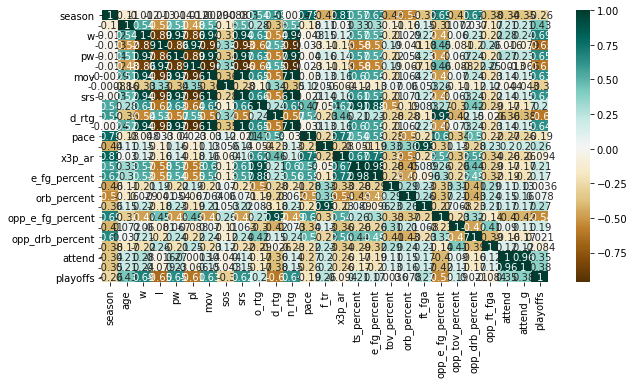

In [43]:
#Correlation Matrix for identifying correlating variables
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(10,5))
c = final_df.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

#Showcasing all the correlations between the variables above 0.75
corr = final_df.corr().drop_duplicates() # df is the pandas dataframe
corr[corr == 1] = 0
c1 = corr.abs().unstack().sort_values()
display(c1[c1> 0.75])

In [44]:
#Delete:
#ts_percent: correlation to e_fg_percent, but higher correlation with o_rtg than ts_percent
#attend_g: only taking attend feature in general into consideration
#n_rtg: high correlation with multiple variables and srs
#srs: high correlation with multiple variables and n_rtg
#f_tr: high correlation with ft_fga
#pw: high correlation with multiple variables
#pl: high correlation with multiple variables
#d_rtg: high correlation with opp_e_fg_percent
#Season: not considered since these correlation seems not have high influence and its legitimacy is questionable


In [1]:
### Building and Training of the Model

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

In [47]:
#select needed colums for model
# ORtg/A = Adjusted Offensive Rating = Points scored per 100 Possesion
# DRtg/A = Adjusted Defensive Rating = Points allowed per 100 Possesion

#df_NBA = final_df[['ORtg_A','DRtg_A','playoffs']]

df_NBA = final_df

In [48]:
#define target value and split test data
#for X we dropped columnes which are not relevant or from previous correlation analysis
X = df_NBA.drop(['playoffs','ts_percent','attend_g','n_rtg','srs','f_tr','pw','pl','d_rtg','Team','Conf','Div','season'],axis=1).values
y = df_NBA['playoffs'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state = 99)



In [49]:
#The input data is not standardised (standardise the data means transform the data so that they have mean 0 and std dev 1). This is a good practise, especially when data have very different ranges.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [50]:
log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)

LogisticRegression()

In [51]:
print(log_reg.coef_)
print(log_reg.intercept_)

[[ 0.05953206  0.53237118 -1.99410141 -0.34470174 -0.53244754 -0.3502395
   0.45529772 -0.08210037 -0.06500274 -0.27418347 -0.20774411  0.92637049
   0.0480695   0.10763431 -0.07247806 -0.05516897  0.99353875  1.43312059
  -0.41595934 -0.64326139 -0.51755642 -0.16977983 -0.18578269]]
[-0.45455261]


In [52]:
y_pred = log_reg.predict(X_test)
y_pred

y_proba = log_reg.predict_proba(X_test)

y_pred = log_reg.predict(X_test) #ADD YOU CODE HERE####

#prediction_df = pd.DataFrame(np.c_[y_proba,y_pred], columns = (['Probability', list(df_NBA.w)[0],
                                                               #'Probability ', list(df_NBA.w)[1], 
                                                               #'Probability ', list(df_NBA.l)[2],
                                                               #'Probability ', list(df_NBA.mov)[3],
                                                               #'Probability ', list(df_NBA.sos)[4],
                                                               #'Probability ', list(df_NBA.o_rtg)[5],
                                                               #'Probability ', list(df_NBA.pace)[6],
                                                               #'Probability ', list(df_NBA.x3p_ar)[7],
                                                               #'Probability ', list(df_NBA.e_fg_percent)[8],
                                                               #'Probability ', list(df_NBA.tov_percent)[9],
                                                               #'Probability ', list(df_NBA.orb_percent)[10],
                                                               #'Probability ', list(df_NBA.ft_fga)[11],
                                                               #'Probability ', list(df_NBA.opp_e_fg_percent)[12],
                                                               #'Probability ', list(df_NBA.opp_tov_percent)[13],
                                                               #'Probability ', list(df_NBA.opp_drb_percent)[14],
                                                               #'Probability ', list(df_NBA.opp_ft_fga)[15],
                                                               #'Probability ', list(df_NBA.attend)[16],
                                                               #'Probability ', list(df_NBA.W_L_Per)[17],
                                                               #'Probability ', list(df_NBA.MOV_A)[18],
                                                               #'Probability ', list(df_NBA.ORtg_A)[19],
                                                               #'Probability ', list(df_NBA.DRtg_A)[20],
                                                               #'Probability ', list(df_NBA.NRtg_A)[21],
                                                               #'Probability ', list(df_NBA.Rk)[22],
                                                               #'Predicted Class']))
#Putting the teams into a seperate df to combine it with the prediction
#teams_df = df_NBA['Team', 'season']

#completion = [teams_df, prediction_df]

#finalprediction_df = pd.concat(completion)

#finalprediction_df

In [53]:
# not needed all Performance Metrics in further code

#mean_accuracy = log_reg.score(X_test, y_test)
#print("The accuracy of your model is {0}%".format(np.round(mean_accuracy*100),2))

The accuracy of your model is 90.0%


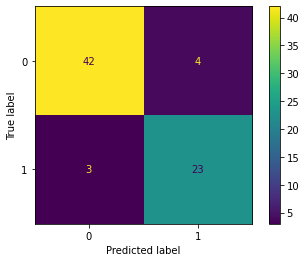

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report # for this plot sklearn >= 1.0.1 is needed

cm = confusion_matrix(y_test, y_pred, labels=log_reg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=log_reg.classes_)
disp.plot()
plt.show()

In [55]:
#  Showing all Performance Metrics from previous Confusion Matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[42  4]
 [ 3 23]]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        46
           1       0.85      0.88      0.87        26

    accuracy                           0.90        72
   macro avg       0.89      0.90      0.90        72
weighted avg       0.90      0.90      0.90        72

